In [1]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data2/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data2/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data2/names/Czech.txt', 'data2/names/German.txt', 'data2/names/Arabic.txt', 'data2/names/Japanese.txt', 'data2/names/Chinese.txt', 'data2/names/Vietnamese.txt', 'data2/names/Russian.txt', 'data2/names/French.txt', 'data2/names/Irish.txt', 'data2/names/English.txt', 'data2/names/Spanish.txt', 'data2/names/Greek.txt', 'data2/names/Italian.txt', 'data2/names/Portuguese.txt', 'data2/names/Scottish.txt', 'data2/names/Dutch.txt', 'data2/names/Korean.txt', 'data2/names/Polish.txt']
Slusarski


In [2]:
import torch
import torch.nn as nn
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

import random
random.seed(333)
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor


In [3]:
'''
torch.nn.RNNCell(input_size, hidden_size, bias=True, nonlinearity='tanh')
Input: input, hidden
    input = input for the cell. # shape: (batch, input_size)
    hidden = previous hidden state for the cell. Defaults to zero. # shape: (batch, hidden_size)
Output: h’
    next hidden state for the cell. # shape: (batch, hidden_size)
'''

'''
torch.nn.LSTMCell(input_size, hidden_size, bias=True)
Input: input,(h0,c0)
    input = input for the cell # shape: (batch, input_size)
    h0 = previous hidden state for the cell # shape: (batch, hidden_size)
    c0 = previous cell state for the cell # shape: (batch, hidden_size)
Output: h1,c1
    h1 = next hidden state for the cell # shape: (batch, hidden_size)
    c1 = next cell state for the cell # shape: (batch, hidden_size)
'''
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTMCell(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input):
        # input [Tx, 1, n_x]
        h = torch.zeros(1, self.hidden_size)
        c = torch.zeros(1, self.hidden_size)
        for i in range(input.size()[0]):
            # h: [1,n_hidden], c: [1,n_hidden]
            h,c = self.lstm(input[i],(h,c))
        # [1, n_y]
        linear = self.h2o(h)
        # [1, n_y]
        output = self.softmax(linear)
        return output

n_hidden = 128

In [4]:
torch.manual_seed(222)
lstm = LSTM(n_letters, n_hidden, n_categories)
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
import torch.optim as optim
optimizer = optim.SGD(lstm.parameters(),lr=learning_rate)

def train2(category_tensor, line_tensor):
    output = lstm(line_tensor)
    # category_tensor [1]
    # line_tensor [Tx, 1, n_x]
    loss = criterion(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return output, loss.item()


In [10]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
# all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train2(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 11s) 0.0068 Arnoni / Italian ✓
10000 10% (0m 23s) 0.3196 Dasios / Greek ✓
15000 15% (0m 36s) 1.3303 Wong / Scottish ✗ (Chinese)
20000 20% (0m 48s) 2.6084 Werrett / German ✗ (English)
25000 25% (1m 0s) 0.2805 Black / Scottish ✓
30000 30% (1m 12s) 0.2471 Jia / Chinese ✓
35000 35% (1m 24s) 1.2862 Sheinfeld / English ✗ (German)
40000 40% (1m 36s) 1.6811 Capello / Spanish ✗ (Italian)
45000 45% (1m 48s) 0.5046 Mclean / Scottish ✓
50000 50% (2m 0s) 1.5877 Martin / French ✗ (Scottish)
55000 55% (2m 13s) 0.4565 Huynh / Vietnamese ✓
60000 60% (2m 25s) 0.7713 Youj / Korean ✓
65000 65% (2m 37s) 0.4511 Voss / German ✓
70000 70% (2m 49s) 0.2619 Krusen / Dutch ✓
75000 75% (3m 1s) 1.5911 Jaso / Korean ✗ (Spanish)
80000 80% (3m 13s) 0.0098 Almeida / Portuguese ✓
85000 85% (3m 25s) 0.9319 Han / Vietnamese ✓
90000 90% (3m 37s) 0.0164 Hanov / Russian ✓
95000 95% (3m 50s) 0.2655 Chellos / Greek ✓
100000 100% (4m 2s) 0.3591 Paget / French ✓


(0, 3)

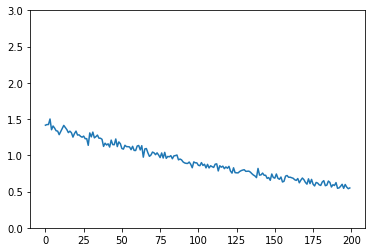

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.ylim(0,3)